In [1]:
import os,re,sys,pickle,datetime,time,random,itertools
import warnings
warnings.filterwarnings("ignore")
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import openpyxl
from openpyxl import load_workbook
import pandas as pd
import math
import seaborn as sns 
import umap
import umap.plot
from PIL import Image
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler,PolynomialFeatures
from sklearn.decomposition import PCA
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
randomstate = 42
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, MolFromSmiles, PandasTools, Descriptors, Draw, PropertyMol, rdmolfiles, rdFMCS
from rdkit import RDConfig
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem.Draw import MolsToGridImage, IPythonConsole, rdMolDraw2D
from rdkit.Chem.Draw.MolDrawing import MolDrawing,DrawingOptions, Font
DrawingOptions.bondLineWidth=1.8
DrawingOptions.includeAtomNumbers=False
size = (150, 150)
import plotly.express as px
import molplotly
import mols2grid
from chembl_webresource_client.new_client import new_client
from IPython.display import SVG

ChEMBL is a manually curated database of (~2 million) bioactive molecules with drug-like properties.

https://github.com/chembl/chembl_webresource_client

https://hub.gke2.mybinder.org/user/chembl-chembl_webresource_client-3ijtqe8j/notebooks/demo_wrc.ipynb (code below from here)

https://www.youtube.com/watch?v=jBlTQjcKuaY

# Search for biologically active compounds against specific target

The target can be a protein, organism, etc. See https://www.ebi.ac.uk/chembl/

In [2]:
target = new_client.target
target_query = target.search('coronavirus')
targets = pd.DataFrame.from_dict(target_query)
targets

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,[],Coronavirus,Coronavirus,17.0,False,CHEMBL613732,[],ORGANISM,11119
1,[],SARS coronavirus,SARS coronavirus,15.0,False,CHEMBL612575,[],ORGANISM,227859
2,[],Feline coronavirus,Feline coronavirus,15.0,False,CHEMBL612744,[],ORGANISM,12663
3,[],Human coronavirus 229E,Human coronavirus 229E,13.0,False,CHEMBL613837,[],ORGANISM,11137
4,"[{'xref_id': 'P0C6U8', 'xref_name': None, 'xre...",SARS coronavirus,SARS coronavirus 3C-like proteinase,10.0,False,CHEMBL3927,"[{'accession': 'P0C6U8', 'component_descriptio...",SINGLE PROTEIN,227859
5,[],Middle East respiratory syndrome-related coron...,Middle East respiratory syndrome-related coron...,9.0,False,CHEMBL4296578,[],ORGANISM,1335626
6,"[{'xref_id': 'P0C6X7', 'xref_name': None, 'xre...",SARS coronavirus,Replicase polyprotein 1ab,4.0,False,CHEMBL5118,"[{'accession': 'P0C6X7', 'component_descriptio...",SINGLE PROTEIN,227859
7,[],Severe acute respiratory syndrome coronavirus 2,Replicase polyprotein 1ab,4.0,False,CHEMBL4523582,"[{'accession': 'P0DTD1', 'component_descriptio...",SINGLE PROTEIN,2697049


Select the appropriate target by its row number (0-indexed)

In [3]:
row_number = 4

selected_target = targets.target_chembl_id[row_number]
print('Selected target ID:',selected_target)

#selected_target = 'CHEMBL2362982'

Selected target ID: CHEMBL3927


Find IC50 data for biologically active compounds with the selected protein

In [8]:
activity = new_client.activity
res = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")
df = pd.DataFrame.from_dict(res)
df = df[df.standard_value.notna()]
df = df[df.canonical_smiles.notna()]
df = df.drop_duplicates(['canonical_smiles'])
selection = ['molecule_chembl_id','canonical_smiles','type','standard_value','units']
df2 = df[selection]
df2

,molecule_chembl_id,canonical_smiles,type,standard_value,units
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,IC50,7200.0,uM
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,IC50,9400.0,uM
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,IC50,13500.0,uM
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,IC50,13110.0,uM
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],IC50,2000.0,uM
...,...,...,...,...,...
109,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,IC50,21100.0,uM
110,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,IC50,226700.0,uM
111,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,IC50,38700.0,uM
112,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,IC50,14400.0,uM


Set a threshold for the standard value

In [9]:
threshold = 10000

bioactivity_thresholds = []
for i in df2.standard_value:
    if float(i) >= threshold:
        bioactivity_thresholds.append("inactive")
    else:
        bioactivity_thresholds.append("active")

bioactivity_class = pd.Series(bioactivity_thresholds, name='class')
df2 = pd.concat([df2, bioactivity_class], axis=1)
df2 = df2[df2['class'] == 'active']
df2.dropna(inplace=True)
df2['standard_value'] = pd.to_numeric(df2['standard_value'])
df2.sort_values(by=['standard_value'],inplace=True)
df2

#df2.to_csv('compound_bioactivity_data.csv', index=False)

,molecule_chembl_id,canonical_smiles,type,standard_value,units,class
15,CHEMBL358279,NC(=O)c1ccc2c(c1)C(=O)C(=O)N2Cc1ccc2ccccc2c1,IC50,370.0,uM,active
78,CHEMBL212454,O=C(Oc1ccc(S(=O)(=O)c2ccc(OC(=O)C(Cl)=C(Cl)Cl)...,IC50,900.0,uM,active
7,CHEMBL190743,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccc(I)cc21,IC50,950.0,uM,active
5,CHEMBL365134,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c(Br)cccc21,IC50,980.0,uM,active
20,CHEMBL383725,O=C1C(=O)N(Cc2ccc3ccccc3c2)c2ccc(I)cc21,IC50,1100.0,uM,active
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],IC50,2000.0,uM,active
6,CHEMBL187598,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccc(F)cc21,IC50,4820.0,uM,active
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,IC50,7200.0,uM,active
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,IC50,9400.0,uM,active


Visualize the biologically active molecules

In [10]:
grid = mols2grid.MolGrid(df2, smiles_col="canonical_smiles", size=(225, 250), name="something")
grid.display(subset=["img","standard_value", "units"], n_cols=4)

# Molecule search

Can use exact name, synonym, single chembl id, multiple chembl ids, or inchi to find the molecule in the ChEMBL database.

In [11]:
molecule = new_client.molecule

#mols = molecule.filter(pref_name__iexact='aspirin')
#mols = molecule.filter(molecule_synonyms__molecule_synonym__iexact='viagra').only('molecule_chembl_id')
#mols = molecule.filter(chembl_id='CHEMBL192').only(['molecule_chembl_id', 'pref_name', 'molecule_structures'])
mols = molecule.filter(molecule_chembl_id__in=['CHEMBL25', 'CHEMBL192', 'CHEMBL27']).only(['molecule_chembl_id', 'pref_name'])
#mol = molecule.filter(molecule_structures__standard_inchi_key='BSYNRYMUTXBXSQ-UHFFFAOYSA-N').only(['molecule_chembl_id', 'pref_name', 'molecule_structures'])

mols

[{'molecule_chembl_id': 'CHEMBL25', 'pref_name': 'ASPIRIN'}, {'molecule_chembl_id': 'CHEMBL27', 'pref_name': 'PROPRANOLOL'}, {'molecule_chembl_id': 'CHEMBL192', 'pref_name': 'SILDENAFIL'}]

**Print molecule using chembl ID**

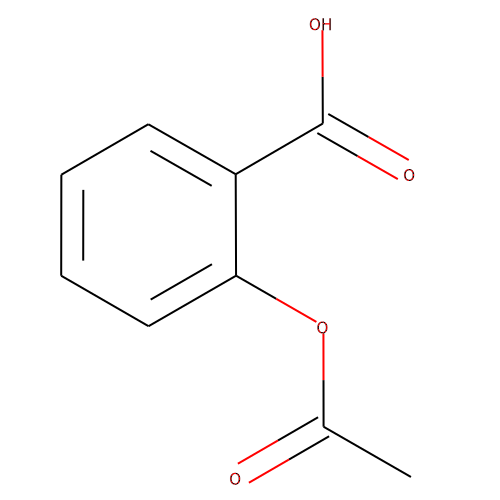

In [12]:
image = new_client.image
image.set_format('svg')
SVG(image.get('CHEMBL25'))

**Molecule similarity search**

SMILES or ID query with similarity threshold of 70%

In [13]:
similarity = new_client.similarity

#res = similarity.filter(smiles="CO[C@@H](CCC#C\C=C/CCCC(C)CCCCC=C)C(=O)[O-]", similarity=70).only(['molecule_chembl_id', 'similarity'])
res = similarity.filter(chembl_id='CHEMBL25', similarity=70).only(['molecule_chembl_id', 'pref_name', 'similarity'])

for i in res:
    print(i)

{'molecule_chembl_id': 'CHEMBL2296002', 'pref_name': None, 'similarity': '100'}
{'molecule_chembl_id': 'CHEMBL1697753', 'pref_name': 'ASPIRIN DL-LYSINE', 'similarity': '100'}
{'molecule_chembl_id': 'CHEMBL3833325', 'pref_name': 'CARBASPIRIN CALCIUM', 'similarity': '88.8888895511627197265625'}
{'molecule_chembl_id': 'CHEMBL3833404', 'pref_name': 'CARBASPIRIN', 'similarity': '88.8888895511627197265625'}
{'molecule_chembl_id': 'CHEMBL350343', 'pref_name': 'DIPLOSALSALATE', 'similarity': '85.7142865657806396484375'}
{'molecule_chembl_id': 'CHEMBL4515737', 'pref_name': None, 'similarity': '70.3703701496124267578125'}
{'molecule_chembl_id': 'CHEMBL1451173', 'pref_name': 'DIPYROCETYL', 'similarity': '69.9999988079071044921875'}


**Get approved drugs**

In [14]:
molecule = new_client.molecule
approved_drugs = molecule.filter(max_phase=4).order_by('molecule_properties__mw_freebase')
approved_drugs

[{'atc_classifications': ['V03AN03'], 'availability_type': 1, 'biotherapeutic': None, 'black_box_warning': 0, 'chebi_par_id': 30217, 'chirality': 2, 'cross_references': [], 'dosed_ingredient': True, 'first_approval': 2015, 'first_in_class': 0, 'helm_notation': None, 'indication_class': 'Gases, Diluent for', 'inorganic_flag': 1, 'max_phase': 4, 'molecule_chembl_id': 'CHEMBL1796997', 'molecule_hierarchy': {'molecule_chembl_id': 'CHEMBL1796997', 'parent_chembl_id': 'CHEMBL1796997'}, 'molecule_properties': {'alogp': None, 'aromatic_rings': None, 'cx_logd': None, 'cx_logp': None, 'cx_most_apka': None, 'cx_most_bpka': None, 'full_molformula': 'He', 'full_mwt': '4.00', 'hba': None, 'hba_lipinski': None, 'hbd': None, 'hbd_lipinski': None, 'heavy_atoms': None, 'molecular_species': None, 'mw_freebase': '4.00', 'mw_monoisotopic': '4.0026', 'num_lipinski_ro5_violations': None, 'num_ro5_violations': None, 'psa': None, 'qed_weighted': None, 'ro3_pass': None, 'rtb': None}, 'molecule_structures': {'ca

In [15]:
len(approved_drugs)

4087

**Protein search**

Get all IC50 activities related to the hERG target

In [ ]:
target = new_client.target
activity = new_client.activity
herg = target.filter(pref_name__iexact='hERG').only('target_chembl_id')[0]
herg_activities = activity.filter(target_chembl_id=herg['target_chembl_id']).filter(standard_type="IC50")

len(herg_activities)